In [1]:

import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
rng = numpy.random

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0050 cost= 0.113439776 W= 0.3564451 b= 0.032784227
Epoch: 0100 cost= 0.109224193 W= 0.35009012 b= 0.07850147
Epoch: 0150 cost= 0.105495684 W= 0.34411314 b= 0.121499576
Epoch: 0200 cost= 0.102197960 W= 0.33849165 b= 0.1619404
Epoch: 0250 cost= 0.099281333 W= 0.33320442 b= 0.19997613
Epoch: 0300 cost= 0.096701741 W= 0.3282317 b= 0.23574954
Epoch: 0350 cost= 0.094420291 W= 0.32355464 b= 0.2693956
Epoch: 0400 cost= 0.092402525 W= 0.3191559 b= 0.3010404
Epoch: 0450 cost= 0.090618014 W= 0.31501868 b= 0.33080304
Epoch: 0500 cost= 0.089039817 W= 0.31112754 b= 0.35879555
Optimization Finished!
Training cost= 0.08903982 W= 0.31112754 b= 0.35879555 

Model saved in path: /tmp/tf/model.ckpt


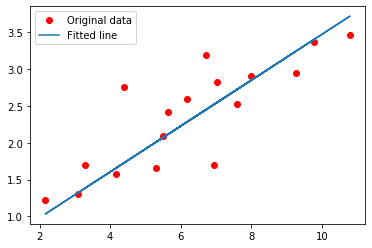

In [2]:
# Parameters
learning_rate = 0.01
training_epochs = 500
display_step = 50
# Training Data
train_X = numpy.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1])
train_Y = numpy.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3])
n_samples = train_X.shape[0]
# tf Graph Input
# You must name the variables and placeholders, as the names will be later used!!!
X = tf.placeholder("float", name='X')
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(rng.randn(), name="weight")
b = tf.Variable(rng.randn(), name="bias")
# Construct a linear model
pred = tf.add(tf.multiply(X, W), b, name='pred')
# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
# Start training
# sess = tf.Session()
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", sess.run(W), "b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')

    # Save the variables to disk.
    save_path = saver.save(sess, "/tmp/tf/model.ckpt")
    print("Model saved in path: %s" % save_path)
    
    #Graphic display - matplotlib
    plt.plot(train_X, train_Y, 'ro', label='Original data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
    plt.legend()
    plt.show()

In [3]:
# import the inspect_checkpoint library
from tensorflow.python.tools import inspect_checkpoint as chkp

# print all tensors in checkpoint file
chkp.print_tensors_in_checkpoint_file("/tmp/tf/model.ckpt", tensor_name='', all_tensors=True)

tensor_name:  bias
0.35879555
tensor_name:  weight
0.31112754
# Total number of params: 2


In [1]:
def predict(sess, inputs):
    preds = sess.run('pred:0', feed_dict={'X:0': inputs}) 
    # `X` is used, it must be defined in the model with that name explicitly!
    return [str(p) for p in preds]

In [5]:

from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin.deployers.tensorflow import deploy_tensorflow_model
clipper_conn = ClipperConnection(DockerContainerManager())

In [6]:
clipper_conn.start_clipper()

20-01-09:20:32:11 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
20-01-09:20:32:15 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /tmp/tmp4qaqfozj.yml
20-01-09:20:32:16 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [7]:
clipper_conn.connect()

20-01-09:20:32:30 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [8]:
# List all applications
clipper_conn.get_all_apps()

[]

In [9]:

# List all models
clipper_conn.get_all_models()

[]

In [10]:

# Add an application with a name and an input type
clipper_conn.register_application(
    name="tf-app", input_type="doubles", default_output="-1.0", slo_micros=100000)

20-01-09:20:33:03 INFO     [clipper_admin.py:236] [default-cluster] Application tf-app was successfully registered


In [11]:

# Deploy a model, to check what arguments you need run 
# "?deploy_tensorflow_model" to let the notebook show you the definition of the method
deploy_tensorflow_model(
    clipper_conn,
    name="tf-mod",
    version=1,
    input_type="doubles",
    func=predict,
    tf_sess_or_saved_model_path="/tmp/tf/") # path to saved model files is used,
# session example in the next section

20-01-09:20:33:17 INFO     [deployer_utils.py:41] Saving function to /tmp/tmptpnbwhg4clipper
20-01-09:20:33:17 INFO     [deployer_utils.py:51] Serialized and supplied predict function
20-01-09:20:33:17 INFO     [tensorflow.py:264] TensorFlow model copied to: tfmodel 
20-01-09:20:33:17 INFO     [tensorflow.py:277] Using Python 3.6 base image
20-01-09:20:33:17 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmptpnbwhg4clipper
20-01-09:20:33:17 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM clipper/tf36-container:0.4.1
20-01-09:20:33:17 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3db42af800ff
20-01-09:20:33:17 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmptpnbwhg4clipper /model/
20-01-09:20:33:17 INFO     [clipper_admin.py:539] [default-cluster]  ---> 8d68c13e2a5c
20-01-09:20:33:17 INFO     [clipper_admin.py:539] [default-cluster] Successfully built 8d68c13e2a5c
20-01-09:20:3

In [12]:
# Link the model and the app
clipper_conn.link_model_to_app(
    app_name="tf-app",
    model_name="tf-mod")


20-01-09:20:34:02 INFO     [clipper_admin.py:303] [default-cluster] Model tf-mod is now linked to application tf-app


In [13]:

# Show the apps again, should list one
clipper_conn.get_all_apps()

['tf-app']

In [14]:
# Get query address
query_address = clipper_conn.get_query_addr()

In [15]:

# Run a query
import requests, json, numpy as np
headers = {"Content-type": "application/json"}
requests.post("http://"+query_address+"/tf-app/predict", headers=headers, data=json.dumps({
    "input": [.8, 3.2]})).json()

{'query_id': 0, 'output': '[0.6076976 1.3544037]', 'default': False}

In [16]:
# Clipper allows to deploy a TensorFlow model using a session variable too
# First the model must be restored from the files
# Pay attention to the fact that variables/placeholders are restored 
# with exactly the same names
tf.reset_default_graph()

W = tf.get_variable("weight", shape=[])
b = tf.get_variable("bias", shape=[])

X = tf.placeholder("float", name='X')
pred = tf.add(tf.multiply(X, W), b, name='pred')

saver = tf.train.Saver()
sess = tf.Session()

# Restore variables from disk.
saver.restore(sess, "/tmp/tf/model.ckpt")
print("Model restored.")
print("W : %s" % W.eval(session=sess))
print("b : %s" % b.eval(session=sess))

INFO:tensorflow:Restoring parameters from /tmp/tf/model.ckpt


20-01-09:20:35:50 INFO     [saver.py:1284] Restoring parameters from /tmp/tf/model.ckpt


Model restored.
W : 0.31112754
b : 0.35879555


In [17]:

# Check that the session variable exists
sess

In [18]:
deploy_tensorflow_model(
    clipper_conn,
    name="tf-mod",
    version=2, # version 2 of the same model, `predict` endpoint will be updated 
    # automatically to the newest model version
    input_type="doubles",
    func=predict,
    tf_sess_or_saved_model_path=sess) # `sess` variable is used here

20-01-09:20:37:33 INFO     [deployer_utils.py:41] Saving function to /tmp/tmpt1hw5uj9clipper
20-01-09:20:37:33 INFO     [deployer_utils.py:51] Serialized and supplied predict function
20-01-09:20:37:33 INFO     [tensorflow.py:196] TensorFlow model saved at: /tmp/tmpt1hw5uj9clipper/tfmodel/model.ckpt 
20-01-09:20:37:33 INFO     [tensorflow.py:277] Using Python 3.6 base image
20-01-09:20:37:33 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmpt1hw5uj9clipper
20-01-09:20:37:33 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM clipper/tf36-container:0.4.1
20-01-09:20:37:33 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3db42af800ff
20-01-09:20:37:33 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmpt1hw5uj9clipper /model/
20-01-09:20:37:33 INFO     [clipper_admin.py:539] [default-cluster]  ---> 9aa8b9159610
20-01-09:20:37:33 INFO     [clipper_admin.py:539] [default-cluster] Successfull

In [19]:

# Session can be closed now
sess.close()

In [20]:
# Run a query
headers = {"Content-type": "application/json"}
requests.post("http://"+query_address+"/tf-app/predict", headers=headers, data=json.dumps({
    "input": [.8, 3.2]})).json()
# The result is the same

{'query_id': 1, 'output': '[0.6076976 1.3544037]', 'default': False}

In [21]:
# You can revert to the previous model version, the query endpoint remains the same
clipper_conn.set_model_version("tf-mod", "1")

In [22]:
# Replicate the model 5 times
clipper_conn.set_num_replicas("tf-mod", 5)

20-01-09:20:38:54 INFO     [docker_container_manager.py:409] [default-cluster] Found 1 replicas for tf-mod:1. Adding 4


In [23]:
# Back to one replica
clipper_conn.set_num_replicas("tf-mod", 1)

20-01-09:20:39:06 INFO     [docker_container_manager.py:427] [default-cluster] Found 5 replicas for tf-mod:1. Removing 4


In [24]:
# You can also register more applications - connections to the model and link them to it
clipper_conn.register_application(
    name="tf-app-extra", input_type="doubles", default_output="-1.0", slo_micros=100000)
# You have to link them the standard way. You can also link an existing application 
# to another model if you wish using the same method
clipper_conn.link_model_to_app(
    app_name="tf-app-extra",
    model_name="tf-mod")

20-01-09:20:41:01 INFO     [clipper_admin.py:236] [default-cluster] Application tf-app-extra was successfully registered
20-01-09:20:41:01 INFO     [clipper_admin.py:303] [default-cluster] Model tf-mod is now linked to application tf-app-extra


In [25]:
# Run a query with an endpoint `tf-app-extra/predict`
headers = {"Content-type": "application/json"}
requests.post("http://"+query_address+"/tf-app-extra/predict", headers=headers, data=json.dumps({
    "input": [.8, 3.2]})).json()

{'query_id': 2, 'output': '[0.6076976 1.3544037]', 'default': False}

In [26]:
# Unlink the model and the apps
clipper_conn.unlink_model_from_app(model_name="tf-mod", app_name="tf-app")
clipper_conn.unlink_model_from_app(model_name="tf-mod", app_name="tf-app-extra")

20-01-09:20:42:03 INFO     [clipper_admin.py:344] Model tf-mod is now removed to application tf-app
20-01-09:20:42:03 INFO     [clipper_admin.py:344] Model tf-mod is now removed to application tf-app-extra


In [27]:
# Stop the model
clipper_conn.stop_models('tf-mod')

20-01-09:20:42:38 INFO     [clipper_admin.py:1285] Model tf-mod:1 was successfully deleted
20-01-09:20:42:38 INFO     [clipper_admin.py:1285] Model tf-mod:2 was successfully deleted
20-01-09:20:42:38 INFO     [clipper_admin.py:1319] [default-cluster] Stopped all containers for these models and versions:
{'tf-mod': ['1', '2']}


In [28]:
# Remove the apps
clipper_conn.delete_application('tf-app')
clipper_conn.delete_application('tf-app-extra')

20-01-09:20:43:08 WARNING  [clipper_admin.py:240] [default-cluster] [DEPRECATED] Use 'unregister_application' API instead of this.
20-01-09:20:43:08 INFO     [clipper_admin.py:260] [default-cluster] Application tf-app was successfully unregistered
20-01-09:20:43:08 WARNING  [clipper_admin.py:240] [default-cluster] [DEPRECATED] Use 'unregister_application' API instead of this.
20-01-09:20:43:08 INFO     [clipper_admin.py:260] [default-cluster] Application tf-app-extra was successfully unregistered


In [29]:
# Stop Clipper
clipper_conn.stop_all()

20-01-09:20:43:58 INFO     [clipper_admin.py:1424] [default-cluster] Stopped all Clipper cluster and all model containers
